In [190]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from torch.utils.data.sampler import Sampler
from torch.utils.data.sampler import RandomSampler
from torch.utils.data import Dataset
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
to_arr = lambda x: x.detach().numpy()
import pickle
def pickle_save(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
def pickle_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f, encoding='latin1')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


to get the data run
```
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 
```

In [4]:
from cifar_utils import get_CIFAR10_data

In [ ]:
data = get_CIFAR10_data(num_training=100, num_validation=200)
for k, v in data.items():
  print('%s: ' % k, v.shape)

In [185]:
X_labeled = data['X_train']
y_labeled = pd.get_dummies(data['y_train']).values
X_unlabeled = data['X_val']

In [187]:
pickle_save((X_labeled, y_labeled, X_unlabeled), 'cifar_subset.pkl')

In [191]:
(X_labeled, y_labeled, X_unlabeled) = pickle_load('cifar_subset.pkl')

In [7]:
from dataset import ArrayDataset, MixupLoader

In [8]:
from torch.utils.data import DataLoader

In [9]:
def augment_fn(x): return x

### Torch Version

In [53]:
from torch import nn
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

model = nn.Sequential(
    nn.Conv2d(3, 2, 3, stride=1, padding=1),
    Flatten(),
    nn.Linear(2 * 32 * 32, 10),
)

In [168]:
class MixUpLoss(nn.Module):
    "Adapt the loss function `crit` to go with mixup."
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) == 2:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            d = (loss1 * target[:,2] + loss2 * (1-target[:,2])).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class MixMatchLoss(torch.nn.Module):
    def __init__(self, lambda_u=100):
        super().__init__()
        self.lambda_u = lambda_u
    def forward(self, preds, y, n_labeled):
        labeled_loss = F.cross_entropy(preds[:n_labeled], y[:n_labeled])
        unlabeled_loss = F.mse(preds[n_labeled:], y[n_labeled:])
        return labeled_loss + (self.lambda_u * unlabeled_loss)

In [177]:
ds = ArrayDataset(X_labeled[:12], y_labeled[:12], X_unlabeled[:12])
BS = 4
loader = MixupLoader(ds, batch_size=BS)

loader.model = model
loss_fn = MixMatchLoss()
for xb,yb in loader:
    #print(x.shape,y.shape)
    #print(np.round(to_arr(yb), 3))
    preds = F.softmax(model.forward(xb), dim=1)
    loss = loss_fn(preds, yb, BS//2)
    print(loss)
    break
#    loss = 
#    brea

beta: torch.Size([2]), x1: torch.Size([2, 3, 32, 32]), x2: torch.Size([2, 3, 32, 32])
beta: torch.Size([4]), x1: torch.Size([4, 3, 32, 32]), x2: torch.Size([4, 3, 32, 32])


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

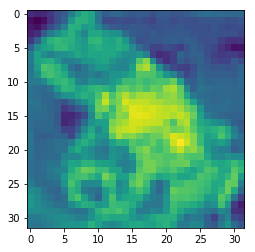

In [127]:
import matplotlib.pyplot as plt
plt.imshow(x[0].detach().numpy()[0])

### (IGNORE ME) NPY Version

In [ ]:
def model_const(stuff):
    return np.random.randn(stuff.shape[0], 10)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
y_ohe = pd.get_dummies(y_labeled).values

In [ ]:
augment_fn = lambda x: x

In [ ]:
K = 2
T = .75
alpha = .4
xb = augment_fn(X_labeled[:4])
n_labeled = 4
ub = [augment_fn(X_unlabeled[:4]) for _ in range(K)]  # unlabeled
qb = sharpen(sum(map(model, ub)) / K, T)
C = np.concatenate
Ux = C(ub, axis=0)
Uy = C([qb for _ in range(K)], axis=0)
indices = np.random.permutation(np.arange(len(xb) + len(Ux)))
Wx = C([Ux, xb], axis=0)[indices]
print(qb.shape, y.shape)
Uy = C([qb for _ in range(K)], axis=0) # same guessed labels regardless of aug
#pd.get_dummies(y)
Wy = C([Uy, y_ohe[:4],], axis=0)[indices]

In [ ]:
indices

In [ ]:
Wy.shape

In [ ]:
Wx.shape

In [ ]:

del lin_comb
def lin_comb(a, b, frac_a): 
    try:
        return (frac_a * a) + (1 - frac_a) * b
    except ValueError:
        return (np.tile(frac_a, a.shape) * a) + np.tile(1 - frac_a, a.shape) * b
            
            
            
            
            
            
X, p = mixup(xb, Wx[:n_labeled], y, Wy[:n_labeled], alpha)
U, q = mixup(Ux, Wx[n_labeled:], Uy, Wy[n_labeled:], alpha)

In [ ]:
exit

In [ ]:



def sharpen(x, T):
    numerator = x ** (1 / T)
    return numerator / numerator.sum(axis=1, keepdims=True)

def matmul(arr, scalar):
    return arr * scalar



def mixup(x1, x2, y1, y2, alpha):
    beta = np.random.beta(alpha, alpha, x1.shape[0])
    beta = np.maximum(beta, 1 - beta)
    return lin_comb(x1, x2, beta), lin_comb(y1, y2, beta)

class MixMatchLoss(torch.nn.Module):
    def __init__(self, lambda_u=100):
        super().__init__()
        self.lambda_u = lambda_u
    def forward(self, preds, y, n_labeled):
        labeled_loss = self.cross_entropy(preds[:n_labeled], y[:n_labeled])
        unlabeled_loss = F.mse(preds[n_labeled:], y[n_labeled:])
        return labeled_loss + (self.lambda_u * unlabeled_loss)

In [ ]:
np.tile(.6, (32,32)).shape

In [ ]:
#resnet18.foa

In [ ]:

class MixMatchLoss(torch.nn.Module):
    def __init__(self, lambda_u=100):
        super().__init__()
        self.lambda_u = lambda_u
        self.xent = torch.nn.CrossEntropyLoss()
        self.mse = torch.nn.MSELoss()

    def forward(self, preds, y, n_labeled):
        labeled_loss = self.xent(preds[:n_labeled], y[:n_labeled])
        unlabeled_loss = self.mse(preds[n_labeled:], y[n_labeled:])
        return labeled_loss + (self.lambda_u * unlabeled_loss)
